In [1]:
# %% init
import os
os.chdir("/home/tangir/crmbm/python/shrimp")

from IPython import get_ipython
get_ipython().magic("clear")
get_ipython().magic("matplotlib notebook")

import matplotlib.pylab as plt
import matplotlib.dates as mdates
import mrs.reco as reco
import mrs.sim as sim
import mrs.db as db
import mrs.log as log
import numpy as np
import pandas as pd
import suspect
from datetime import datetime

plt.close("all")
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
log.setLevel(log.DEBUG)

pd.options.mode.chained_assignment = None  # default='warn'

# Select datasets
Load datasets from SC and brain

In [2]:
rdb_sc = db.data_db("/home/tangir/crmbm/acq_db/sc.pkl")
rdb_brain = db.data_db("/home/tangir/crmbm/acq_db/brain.pkl")

(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/sc.pkl]...
(DEBUG) data_db._read_db_file: finished reading!
(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/brain.pkl]...
(DEBUG) data_db._read_db_file: finished reading!


In [3]:
df = rdb_sc.create_big_df(True)
df_brain = rdb_brain.create_big_df(True)

# remove db objects to free memory
del(rdb_sc)
del(rdb_brain)

df

(INFO)  data_db.create_big_df: extending dataframe by scraping data...
(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/sc.pkl]...
(DEBUG) data_db._read_db_file: finished reading!
(INFO)  data_db.create_big_df: extending dataframe by scraping data...
(DEBUG) data_db._read_db_file: reading db file [/home/tangir/crmbm/acq_db/brain.pkl]...
(DEBUG) data_db._read_db_file: finished reading!


,patient,study,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data_obj,dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,...,reco_pipeline_job_list[7]_display_range_ppm[1],reco_pipeline_job_list[8]_POI_shift_range_ppm[0],reco_pipeline_job_list[8]_POI_shift_range_ppm[1],reco_pipeline_job_list[8]_POI_shift_true_ppm,reco_pipeline_job_list[9]_final_npts,reco_pipeline_job_list[10]_fig_index,reco_pipeline_job_list[10]_range_ppm[0],reco_pipeline_job_list[10]_range_ppm[1],reco_pipeline_job_list[10]_magnitude_mode,reco_pipeline_settings_datasets_indexes[0]
hash,,,,,,,,,,,,,,,,,,,,,
5010227e1b906e17fdeac0fdff8396b2,296,1,#0 STEAM,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(5.906507327308433+113.6085493880716j), (-39....",0.0001,297.205422,3.48,3000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
405976f0de3db2b1ea8b83c3accc8994,296,1,#1 sLASER R:N=20:1,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(328.82776378508504+27.216353213341588j), (31...",0.0001,297.205422,49.96,3690.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fb81785a61e346c7fdbb37479f312ca5,300,1,#0 sLASER R:N=25:1,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,"[(426.508162270165-25.29576424165769j), (419.8...",0.0001,297.206850,49.96,3550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2fff316122fc89a0b4d1f918f6cd62d8,300,1,#1 sLASER R:N=25:1 trig,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,"[(466.7910467092009+42.6625311942012j), (449.5...",0.0001,297.206850,49.96,3550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77db8d723204884d29a997944390611b,304,1,#0 crappy,/home/tangir/crmbm/acq/304-ka-p1-moelle/201908...,/home/tangir/crmbm/acq/304-ka-p1-moelle/201908...,"[(936.8425903320312+83.49891662597656j), (740....",0.0002,297.204465,49.96,4610.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40ef3af628211f936a93c79adb00ac9d,307,1,#0 sLASER 20:1 cardiac trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(407.49602726268415-207.9086346239237j), (425...",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159437f4b7de93d40c7fef7853019df3,307,1,#1 sLASER 20:1 resp trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(498.05689346512656+329.8932319576538j), (420...",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4a3a0b1b9f85f1928b9bfb342358fef4,307,1,#2 sLASER 20:1 no trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(509.3192079352583+42.15127719925854j), (507....",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1baf6b702f39fefb5ad9e44179057ef7,307,1,#3 sLASER 10:2 repos. + resp trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(781.0128721121888-57.03888725364891j), (754....",0.0001,297.205912,29.96,4570.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Adding additional columns
Like BMI, BFP, etc.

In [4]:
import datetime
this_year = datetime.date.today().year

# create a patient*study id number
df["patient_study_id"] = df["patient"].astype(str) + "_" + df["study"].astype(str)
df_brain["patient_study_id"] = df_brain["patient"].astype(str) + "_" + df_brain["study"].astype(str)

# calculate bmi
df["dataset_patient_bmi"] = df["dataset_raw_data__patient_weight"] / \
    df["dataset_raw_data__patient_height"]**2

# calculate BFP (IMG)
df["dataset_patient_bfp"] = 1.39 * df["dataset_patient_bmi"]
+ 0.16 * (this_year - pd.DatetimeIndex(df["dataset_raw_data__patient_birthday"]).year)
- 10.34 * (df["dataset_raw_data__patient_sex"] == "M").astype(int)
- 9

df

,patient,study,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data_obj,dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,...,reco_pipeline_job_list[8]_POI_shift_true_ppm,reco_pipeline_job_list[9]_final_npts,reco_pipeline_job_list[10]_fig_index,reco_pipeline_job_list[10]_range_ppm[0],reco_pipeline_job_list[10]_range_ppm[1],reco_pipeline_job_list[10]_magnitude_mode,reco_pipeline_settings_datasets_indexes[0],patient_study_id,dataset_patient_bmi,dataset_patient_bfp
hash,,,,,,,,,,,,,,,,,,,,,
5010227e1b906e17fdeac0fdff8396b2,296,1,#0 STEAM,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(5.906507327308433+113.6085493880716j), (-39....",0.0001,297.205422,3.48,3000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296_1,20.061728,27.885802
405976f0de3db2b1ea8b83c3accc8994,296,1,#1 sLASER R:N=20:1,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(328.82776378508504+27.216353213341588j), (31...",0.0001,297.205422,49.96,3690.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296_1,20.061728,27.885802
fb81785a61e346c7fdbb37479f312ca5,300,1,#0 sLASER R:N=25:1,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,"[(426.508162270165-25.29576424165769j), (419.8...",0.0001,297.206850,49.96,3550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300_1,21.913806,30.460190
2fff316122fc89a0b4d1f918f6cd62d8,300,1,#1 sLASER R:N=25:1 trig,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,"[(466.7910467092009+42.6625311942012j), (449.5...",0.0001,297.206850,49.96,3550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300_1,21.913806,30.460190
77db8d723204884d29a997944390611b,304,1,#0 crappy,/home/tangir/crmbm/acq/304-ka-p1-moelle/201908...,/home/tangir/crmbm/acq/304-ka-p1-moelle/201908...,"[(936.8425903320312+83.49891662597656j), (740....",0.0002,297.204465,49.96,4610.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,304_1,19.257029,26.767270
40ef3af628211f936a93c79adb00ac9d,307,1,#0 sLASER 20:1 cardiac trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(407.49602726268415-207.9086346239237j), (425...",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
159437f4b7de93d40c7fef7853019df3,307,1,#1 sLASER 20:1 resp trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(498.05689346512656+329.8932319576538j), (420...",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
4a3a0b1b9f85f1928b9bfb342358fef4,307,1,#2 sLASER 20:1 no trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(509.3192079352583+42.15127719925854j), (507....",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
1baf6b702f39fefb5ad9e44179057ef7,307,1,#3 sLASER 10:2 repos. + resp trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(781.0128721121888-57.03888725364891j), (754....",0.0001,297.205912,29.96,4570.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702


## Show badly fitted SC datasets
using FQN and R2, just to check things and reco/refit if necessary

In [5]:
rsq_f_threshold = 0.6
fqn_threshold = 3
fit_strategies_list = ['singlets', 
                       'singlets_free', 
                       'singlets_CH2s_mI', 
                       'free_singlets_CH2s_mI', 
                       'singlets_CH2s_mI_Glx_Tau', 
                       'free_singlets_CH2s_mI_Glx_Tau']

df_bad_fit = df.loc[(df["fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_rsq_f"] < rsq_f_threshold)
                    & (df["fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_fqn"] > fqn_threshold)]

k = 0
for this_index, this_row in df_bad_fit.iterrows():
    s = this_row["dataset_raw_data_obj"]
    if(s is None):
        s = this_row["dataset_dcm_data_obj"]
    
    s.set_display_offset(20000.0 * k)
    s.display_spectrum_1d(100)
    k += 1
    
df_bad_fit[["patient", "study", "dataset_legend", "dataset_raw_analysis-results_cropping_snr", "dataset_raw_analysis-results_cropping_lw"]]

(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sLASER 10:2 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sLASER 10:2 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [DCM]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


,patient,study,dataset_legend,dataset_raw_analysis-results_cropping_snr,dataset_raw_analysis-results_cropping_lw
hash,,,,,
9f8067ea065153da5b3a352d58f6ca23,313,1,#0 sLASER 20:1,19.912865,19.531250
3c700829d5feb605285c5ef7cfad4055,319,1,#0 sLASER 20:1,18.097421,11.393229
f416f6db6cda52195e3b8046fc586ef2,319,1,#1 sLASER 10:2,35.840251,13.020833
2a9fe3c48c69e575db0a8eeeb202d44d,329,1,#1 sLASER 10:2,36.908073,21.158854
3695a02a4fbf0153215cf09eaa21658e,333,1,#0 sLASER 20:1,38.341880,211.588542


## Keep only resp-gating sLASER scans
Keep only:
* semi-LASER scans
* with resp gating
and check that it does not remove any patient of study

In [6]:
n_patient_study_before_filtering = df["patient_study_id"].nunique()

# keep this for big stats about data quality
df_slaser = df.loc[(df["dataset_raw_data__sequence_name"] == "eja_svs_slaser")]
df_brain_slaser = df_brain.loc[df_brain["dataset_raw_data__sequence_name"] == "eja_svs_slaser"]

df_slaser_resptrig = df.loc[(df["dataset_raw_data__sequence_name"] == "eja_svs_slaser")
                          & (df["dataset_raw_data__sequence_gating_mode"] == sim.gating_signal_source.RESP_GATING)]

df_removed = df.loc[(df["dataset_raw_data__sequence_name"] != "eja_svs_slaser")
                  | (df["dataset_raw_data__sequence_gating_mode"] != sim.gating_signal_source.RESP_GATING)]

# check that we did not remove any patient/study
n_patient_study_after_filtering = df_slaser_resptrig["patient_study_id"].nunique()

df_removed

,patient,study,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data_obj,dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,...,reco_pipeline_job_list[8]_POI_shift_true_ppm,reco_pipeline_job_list[9]_final_npts,reco_pipeline_job_list[10]_fig_index,reco_pipeline_job_list[10]_range_ppm[0],reco_pipeline_job_list[10]_range_ppm[1],reco_pipeline_job_list[10]_magnitude_mode,reco_pipeline_settings_datasets_indexes[0],patient_study_id,dataset_patient_bmi,dataset_patient_bfp
hash,,,,,,,,,,,,,,,,,,,,,
5010227e1b906e17fdeac0fdff8396b2,296,1,#0 STEAM,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(5.906507327308433+113.6085493880716j), (-39....",0.0001,297.205422,3.48,3000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296_1,20.061728,27.885802
405976f0de3db2b1ea8b83c3accc8994,296,1,#1 sLASER R:N=20:1,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(328.82776378508504+27.216353213341588j), (31...",0.0001,297.205422,49.96,3690.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,296_1,20.061728,27.885802
fb81785a61e346c7fdbb37479f312ca5,300,1,#0 sLASER R:N=25:1,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,"[(426.508162270165-25.29576424165769j), (419.8...",0.0001,297.206850,49.96,3550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300_1,21.913806,30.460190
77db8d723204884d29a997944390611b,304,1,#0 crappy,/home/tangir/crmbm/acq/304-ka-p1-moelle/201908...,/home/tangir/crmbm/acq/304-ka-p1-moelle/201908...,"[(936.8425903320312+83.49891662597656j), (740....",0.0002,297.204465,49.96,4610.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,304_1,19.257029,26.767270
40ef3af628211f936a93c79adb00ac9d,307,1,#0 sLASER 20:1 cardiac trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(407.49602726268415-207.9086346239237j), (425...",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
4a3a0b1b9f85f1928b9bfb342358fef4,307,1,#2 sLASER 20:1 no trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(509.3192079352583+42.15127719925854j), (507....",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
90a5b0c9d27daa2396d73e53f5a90afe,355,1,#0 sLASER TE=52ms,/home/tangir/crmbm/acq_twix/355-st-p1-moelle/m...,/home/tangir/crmbm/acq_twix/355-st-p1-moelle/m...,"[(407.26385440251784-8.685654423232418j), (368...",0.0001,297.205545,52.48,5390.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,355_1,27.681661,38.477509
caf8ec7f9e1026afbfa1e2c41ba43539,311,2,#1 sLASER 20/1 NA=128 notrig,/home/tangir/crmbm/acq_twix/311-sl-p2-moelle/m...,/home/tangir/crmbm/acq_twix/311-sl-p2-moelle/m...,"[(273.0080880478138+48.28108955825748j), (269....",0.0001,297.206030,52.48,5410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311_2,23.566632,32.757619
49872ea4c73b9206c804c4fdaa298ed9,336,2,#1 sLASER 20/1 NA=64 notrig,/home/tangir/crmbm/acq_twix/336-nb-p2-moelle/m...,/home/tangir/crmbm/acq_twix/336-nb-p2-moelle/m...,"[(214.2803366718213+30.293871740800583j), (240...",0.0001,297.205316,52.36,5220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,336_2,19.721037,27.412241


In [7]:
if(n_patient_study_before_filtering != n_patient_study_after_filtering):
    log.warning("we removed some patient or study from the db: %d vs %d" % (n_patient_study_before_filtering, n_patient_study_after_filtering))


(WARNING) <ipython-input-7-b04a913462c2>.<module>: we removed some patient or study from the db: 27 vs 24


I have been going over the datasets rejected here:

* 296_ym_p1_brainmoelle: one of the first SC scans, was not resp gating at the time, too bad but only P1 (no P2)
* 300_pm_p1_moelle: removing one no gating scan, there is another one with trig so OK
* 304_ka_p1_moelle: removing this P1 study (there is a P2 that will be considered P1), data was crappy, dicom only, and no trig for some reason
* 307_ap_p1_moelle: removing 2 scans (no trig and cardiac trig) that were done for tests, still a 2 resp trig left)
* 355_st_p1_moelle: removing scan and therefore patient, no resp trig because I was in hurry. Too bad, the data is not soo bad and it was a fat guy (cohort stats) :(
* 311_sl_p2_moelle, 336_nb_p2_moelle: just some trig tests removed, no patient or study removed

So removed 3 patient or study in total because not following the standard protocol (semiLASER + resp gating)

## Find any orphan P2 studies
and set them as P1 :)

In [8]:
# using previously filtered db
df = df_slaser_resptrig

# init new df
df_orphan_p2_fix = pd.DataFrame(columns=df.columns)

# browse the df
for this_index, this_row in df.iterrows():
    # if meet a P2 study
    if(this_row["study"] == 2):
        # get the patient
        this_patient = this_row["patient"]
        # find corresponding P1
        df_patient_p1 = df.loc[(df["patient"] == this_patient)
                             & (df["study"] == 1)]
        # if empty
        if(df_patient_p1.empty):
            # change the P2 we are on into a P1
            this_row["study"] = 1
    
    # store it
    df_orphan_p2_fix = df_orphan_p2_fix.append([this_row])
        
        
df_orphan_p2_fix

,patient,study,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data_obj,dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,...,reco_pipeline_job_list[8]_POI_shift_true_ppm,reco_pipeline_job_list[9]_final_npts,reco_pipeline_job_list[10]_fig_index,reco_pipeline_job_list[10]_range_ppm[0],reco_pipeline_job_list[10]_range_ppm[1],reco_pipeline_job_list[10]_magnitude_mode,reco_pipeline_settings_datasets_indexes[0],patient_study_id,dataset_patient_bmi,dataset_patient_bfp
2fff316122fc89a0b4d1f918f6cd62d8,300,1,#1 sLASER R:N=25:1 trig,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,"[(466.7910467092009+42.6625311942012j), (449.5...",0.0001,297.206850,49.96,3550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300_1,21.913806,30.460190
159437f4b7de93d40c7fef7853019df3,307,1,#1 sLASER 20:1 resp trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(498.05689346512656+329.8932319576538j), (420...",0.0001,297.206696,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
1baf6b702f39fefb5ad9e44179057ef7,307,1,#3 sLASER 10:2 repos. + resp trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(781.0128721121888-57.03888725364891j), (754....",0.0001,297.205912,29.96,4570.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
a2b582b37a04bd4efc43138368bc0b96,308,1,#0 sLASER 20:1 resp trig,/home/tangir/crmbm/acq_twix/308-rs-p1-moelle/m...,/home/tangir/crmbm/acq_twix/308-rs-p1-moelle/m...,"[(425.20132747556744+26.922286521821697j), (40...",0.0001,297.204864,41.96,3780.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308_1,17.777778,24.711111
01a46c3d8ebdb2912567745a61ef0d24,310,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/310-mg-p1-moelle/m...,/home/tangir/crmbm/acq_twix/310-mg-p1-moelle/m...,"[(521.3062355513863+231.5798734836309j), (446....",0.0001,297.205166,58.48,5060.0,...,4.7,6144.0,1.0,1.0,6.0,0.0,NaN,310_1,18.991965,26.398831
7cb024e470b0b2b072436635a19a1c00,311,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/311-sl-p1-moelle/m...,/home/tangir/crmbm/acq_twix/311-sl-p1-moelle/m...,"[(454.6048151740534-114.46837806711163j), (472...",0.0001,297.205785,90.00,5810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311_1,22.920971,31.860150
9f8067ea065153da5b3a352d58f6ca23,313,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/313-ft-p1-moelle/m...,/home/tangir/crmbm/acq_twix/313-ft-p1-moelle/m...,"[(1108.8833324440807-501.8758589220622j), (116...",0.0001,297.206221,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313_1,20.545694,28.558514
0a58f85af8c32d06cbbca74391447ad2,314,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/314-yt-p1-moelle/m...,/home/tangir/crmbm/acq_twix/314-yt-p1-moelle/m...,"[(730.3440293819107-125.91066233625389j), (712...",0.0001,297.205966,41.68,4130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314_1,19.111111,26.564444
2195967ae34d5ef7dcfba4fc93a9e121,314,1,#1 sLASER 5:5,/home/tangir/crmbm/acq_twix/314-yt-p1-moelle/m...,/home/tangir/crmbm/acq_twix/314-yt-p1-moelle/m...,"[(1008.4807903081726-17.76038805871182j), (881...",0.0001,297.205946,19.96,3690.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314_1,19.111111,26.564444
fe34c6902afd341a0c81de0a0b6d6373,316,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/316-ap-p1-moelle/m...,/home/tangir/crmbm/acq_twix/316-ap-p1-moelle/m...,"[(526.3710825321402-109.50225527879674j), (518...",0.0001,297.205277,45.96,4010.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316_1,20.202020,28.080808


## Keep only one scan per study
Now, on resp-gating sLASER, keep only one scan per study based on SNR and LW. This is the core group that will be used for the paper's stats.

In [9]:
# using previously filtered db
df = df_orphan_p2_fix

n_patient_study_before_filtering = df["patient_study_id"].nunique()

df_onescan_per_study = pd.DataFrame(columns=df.columns)
patient_study_id_done = []
for this_index, this_row in df.iterrows():
    # find duplicates
    if(this_row["patient_study_id"] not in patient_study_id_done):
        this_df_dup = df.loc[df["patient_study_id"] == this_row["patient_study_id"]]
        this_df_dup_best_snr = this_df_dup.loc[this_df_dup["dataset_raw_analysis-results_cropping_snr"] == this_df_dup["dataset_raw_analysis-results_cropping_snr"].max()]
        df_onescan_per_study = df_onescan_per_study.append([this_df_dup_best_snr])
        patient_study_id_done.append(this_row["patient_study_id"])

n_patient_study_after_filtering = df_onescan_per_study["patient_study_id"].nunique()

if(n_patient_study_before_filtering != n_patient_study_after_filtering):
    log.warning("we removed some patient or study from the db: %d vs %d" % (n_patient_study_before_filtering, n_patient_study_after_filtering))

df_onescan_per_study

,patient,study,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data_obj,dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,...,reco_pipeline_job_list[8]_POI_shift_true_ppm,reco_pipeline_job_list[9]_final_npts,reco_pipeline_job_list[10]_fig_index,reco_pipeline_job_list[10]_range_ppm[0],reco_pipeline_job_list[10]_range_ppm[1],reco_pipeline_job_list[10]_magnitude_mode,reco_pipeline_settings_datasets_indexes[0],patient_study_id,dataset_patient_bmi,dataset_patient_bfp
2fff316122fc89a0b4d1f918f6cd62d8,300,1,#1 sLASER R:N=25:1 trig,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,/home/tangir/crmbm/acq_twix/300-pm-p1-moelle/m...,"[(466.7910467092009+42.6625311942012j), (449.5...",0.0001,297.206850,49.96,3550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300_1,21.913806,30.460190
1baf6b702f39fefb5ad9e44179057ef7,307,1,#3 sLASER 10:2 repos. + resp trig,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,/home/tangir/crmbm/acq_twix/307-AP-P1-MOELLE/m...,"[(781.0128721121888-57.03888725364891j), (754....",0.0001,297.205912,29.96,4570.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,307_1,22.832879,31.737702
a2b582b37a04bd4efc43138368bc0b96,308,1,#0 sLASER 20:1 resp trig,/home/tangir/crmbm/acq_twix/308-rs-p1-moelle/m...,/home/tangir/crmbm/acq_twix/308-rs-p1-moelle/m...,"[(425.20132747556744+26.922286521821697j), (40...",0.0001,297.204864,41.96,3780.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308_1,17.777778,24.711111
01a46c3d8ebdb2912567745a61ef0d24,310,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/310-mg-p1-moelle/m...,/home/tangir/crmbm/acq_twix/310-mg-p1-moelle/m...,"[(521.3062355513863+231.5798734836309j), (446....",0.0001,297.205166,58.48,5060.0,...,4.7,6144.0,1.0,1.0,6.0,0.0,NaN,310_1,18.991965,26.398831
7cb024e470b0b2b072436635a19a1c00,311,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/311-sl-p1-moelle/m...,/home/tangir/crmbm/acq_twix/311-sl-p1-moelle/m...,"[(454.6048151740534-114.46837806711163j), (472...",0.0001,297.205785,90.00,5810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311_1,22.920971,31.860150
9f8067ea065153da5b3a352d58f6ca23,313,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/313-ft-p1-moelle/m...,/home/tangir/crmbm/acq_twix/313-ft-p1-moelle/m...,"[(1108.8833324440807-501.8758589220622j), (116...",0.0001,297.206221,49.96,4290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,313_1,20.545694,28.558514
0a58f85af8c32d06cbbca74391447ad2,314,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/314-yt-p1-moelle/m...,/home/tangir/crmbm/acq_twix/314-yt-p1-moelle/m...,"[(730.3440293819107-125.91066233625389j), (712...",0.0001,297.205966,41.68,4130.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314_1,19.111111,26.564444
5f9a42662bfe3586bee57f3ead964778,316,1,#1 sLASER 5:5,/home/tangir/crmbm/acq_twix/316-ap-p1-moelle/m...,/home/tangir/crmbm/acq_twix/316-ap-p1-moelle/m...,"[(535.8489858681635+21.802746814175052j), (534...",0.0001,297.205276,21.16,3490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316_1,20.202020,28.080808
f416f6db6cda52195e3b8046fc586ef2,319,1,#1 sLASER 10:2,/home/tangir/crmbm/acq_twix/319-fc-p1-moelle/m...,/home/tangir/crmbm/acq_twix/319-fc-p1-moelle/m...,"[(1760.5827174966569-749.9357520232237j), (188...",0.0001,297.205787,38.96,6190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319_1,24.724520,34.367083
b9875913db5c0f321922f819401cc02e,328,1,#0 sLASER 20:1,/home/tangir/crmbm/acq_twix/328-af-p1-moelle/m...,/home/tangir/crmbm/acq_twix/328-af-p1-moelle/m...,"[(343.0588823233081-161.2041404346132j), (367....",0.0001,297.205548,50.28,4840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328_1,23.140496,32.165289


## Separate P1 and P2 studies
Separate those two datasets in different dataframes and start working on P1

In [10]:
# using previously filtered db
df = df_onescan_per_study

df_p1_and_p2 = df_onescan_per_study 
df_p1 = df.loc[(df["study"] == 1)]
df_p2 = df.loc[(df["study"] == 2)]
df = df_p1

## Keep only one scan for brain
The best one in terms of SNR/LW

In [11]:
df_brain_best_snr = df_brain.loc[df_brain["dataset_raw_analysis-results_cropping_snr"] == df_brain["dataset_raw_analysis-results_cropping_snr"].max()]
df_brain_best_snr["dataset_raw_data_obj"][0].display_spectrum_1d()
df_brain = df_brain_best_snr
df_brain

(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 brain - sLASER R:N=25:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

,patient,study,dataset_legend,dataset_raw_files[0],dataset_raw_files[1],dataset_raw_data_obj,dataset_raw_data__dt,dataset_raw_data__f0,dataset_raw_data__te,dataset_raw_data__tr,...,fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_status,fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_message,fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_success,fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_rsq_t,fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_rsq_f,fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_fqn,fit_results_free_singlets_CH2s_mI_Glx_Tau_fittool,timestamp,reco_pipeline_settings_datasets_indexes,patient_study_id
hash,,,,,,,,,,,,,,,,,,,,,
b057a3e07319341e032e3c6c36ec4d83,296,1,#1 brain - sLASER R:N=25:1,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,/home/tangir/crmbm/acq_twix/296_ym_p1_brainmoe...,"[(689.0669802502591-136.65124370561344j), (671...",0.0001,297.206367,49.96,3500.0,...,3,`xtol` termination condition is satisfied.,True,0.920078,0.916673,5.266927,<mrs.fit.fit_tool object at 0x7fb512fd0690>,2020-10-29 11:16:05.254286,NaN,296_1


# Cohort & spectral quality

## Subject, height, weight, BMI, BFP
To check cohort characteristics

In [12]:
# select df
df = df_p1

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_raw_data__patient_weight"],
                df["dataset_raw_data__patient_height"],
                c=df["dataset_patient_bmi"],
                s=100, cmap=cm)
ax.set_xlabel("Patient weight (kg)", fontsize=11)
ax.set_ylabel("Patient height (m)", fontsize=11)
ax.set_title("Patient height vs. weight vs. BMI")
ax.grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_raw_data__patient_weight"],
                df["dataset_raw_data__patient_height"],
                c=df["dataset_patient_bfp"],
                s=100, cmap=cm)
ax.set_xlabel("Patient weight (kg)", fontsize=11)
ax.set_ylabel("Patient height (m)", fontsize=11)
ax.set_title("Patient height vs. weight vs. BFP")
ax.grid(True)

plt.colorbar(sc)
fig.tight_layout()
plt.show()

print("Mean weight = %.2fkgs +/-%.2f " % (df["dataset_raw_data__patient_weight"].mean(),
                                          df["dataset_raw_data__patient_weight"].std()))
print("Mean height = %.2fm +/-%.2f " % (df["dataset_raw_data__patient_height"].mean(),
                                        df["dataset_raw_data__patient_height"].std()))
print("Mean BMI = %.2f +/-%.2f " % (df["dataset_patient_bmi"].mean(), 
                                    df["dataset_patient_bmi"].std()))

sex_counts = df["dataset_raw_data__patient_sex"].value_counts()
print("Sex = M(%d) F(%d)" % (sex_counts["M"], sex_counts["F"]))

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5131ed450>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5131ed450> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5127acc50>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5127acc50> on colorbar
(DEBUG) Setting pcolormesh


Mean weight = 56.81kgs +/-13.69 
Mean height = 1.66m +/-0.12 
Mean BMI = 20.22 +/-2.70 
Sex = M(5) F(11)


## Correlation $B_1$ power (reference voltage) vs. BMI?
Reference RF voltage increases with BMI

In [13]:
# work on extended df
df = df_slaser

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_raw_data__patient_weight"], df["dataset_raw_data__patient_height"],
                   c=df["dataset_raw_data__sequence_vref"], s=100, cmap=cm)
ax.set_xlabel("Patient weight (kg)", fontsize=11)
ax.set_ylabel("Patient height (m)", fontsize=11)
ax.set_title("Patient height vs. height vs. Ref. voltage", fontsize=11)
ax.grid(True)
plt.colorbar(sc)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bmi"],
                   df["dataset_raw_data__sequence_vref"], s=100)
ax.set_xlabel("Patient BMI", fontsize=11)
ax.set_ylabel("Reference voltage (V)", fontsize=11)
ax.set_title("Ref. voltage vs. BMI", fontsize=11)
ax.grid(True)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bfp"],
                   df["dataset_raw_data__sequence_vref"], s=100)
ax.set_xlabel("Patient BFP (%)", fontsize=11)
ax.set_ylabel("Reference voltage (V)", fontsize=11)
ax.set_title("Ref. voltage vs. BFP", fontsize=11)
ax.grid(True)

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb517a6fc10>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb517a6fc10> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Correlation voxel position vs. BMI?
Voxel position relative to magnet center increases with BMI

In [14]:
# work on extended df
df = df_slaser

# add voxel position to df
df["dataset_raw_data_posX_mm"] = np.array([o.position[0] for o in df["dataset_raw_data_obj"]])
df["dataset_raw_data_posY_mm"] = np.array([o.position[1] for o in df["dataset_raw_data_obj"]])
df["dataset_raw_data_posZ_mm"] = np.array([o.position[2] for o in df["dataset_raw_data_obj"]])

fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bmi"], -df["dataset_raw_data_posY_mm"], s=100)
ax.set_xlabel("Patient BMI", fontsize=11)
ax.set_ylabel("- Voxel Y position rel. to MRI center", fontsize=11)
ax.set_title("Patient BMI vs. voxel Y position", fontsize=11)
ax.grid(True)

fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bfp"], -df["dataset_raw_data_posY_mm"], s=100)
ax.set_xlabel("Patient BFP (%)", fontsize=11)
ax.set_ylabel("- Voxel Y position rel. to MRI center", fontsize=11)
ax.set_title("Patient BFP vs. voxel Y position", fontsize=11)
ax.grid(True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Any correlation between SNR, LW, BMI?
SNR is normalized by:
* voxel size
* number of averages (post-data-rejection)
* voxel position in Y

Therefore
* SNR values are divided by voxel volume and multiplied by a mean volume to get usual SNR values
* SNR values are divided by $\sqrt(NA)$ kept after data rejection and multiplied by $\sqrt(128)$
* SNR values are multiplied by $(1+\frac{y^2}{R^2})^{\frac{2}{3}}$ and multiplied by $(1+\frac{y_{mean}^2}{R^2})^{\frac{2}{3}}$

According to the Biot–Savart law (Jackson, 1975), cited in https://doi.org/10.1201/9781315107325, the distance relative to the RF loop surface coil impacts SNR with a $(1+\frac{y^2}{R^2})^{\frac{2}{3}}$ term. $y$ is the absolute distance between the voxel and the RF coil, $R$ is the coil radius. $y_{mean}$ is the average $y$ position over the whole group.

The problem is to evaluate this absolute distance to coil when I only know the voxel position relative to the magnet center... Let's take the lowest voxel position in the study group, probably for the thinnest subject and consider that we were 4cm away from the coil.

Ok, another problem is that we were using a multi-channel Rx spinal cord coil. What do I put for the radius? Assuing a 14cm radius coil... Big approximation.

In [15]:
# work on extended df
df = df_slaser

# init SNR and LW with final estimations
df["dataset_snr_final"] = df["dataset_raw_analysis-results_cropping_snr"]
df["dataset_lw"] = df["dataset_raw_analysis-results_cropping_lw"]
df["dataset_snr_norm"] = df["dataset_raw_analysis-results_cropping_snr"]

# VOI normalization
# calculate voxel volume
df["dataset_voxel_vol_cm3"] = (np.array(list(df["dataset_raw_data_voxel_dimensions"])) / 10.0).prod()
mean_voxel_vol = df["dataset_voxel_vol_cm3"].mean()
df["dataset_snr_norm"] = df["dataset_snr_norm"] / df["dataset_voxel_vol_cm3"] * mean_voxel_vol

# NA normalization
na_norm = 128.0
df["dataset_snr_norm"] = df["dataset_snr_norm"] / np.sqrt(df["dataset_raw_data__data_rejection[0]_Post-rejection_na"]) * np.sqrt(na_norm)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm"], c=df["dataset_patient_bmi"], s=100, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. LW vs. BMI")
ax.grid(True)
plt.colorbar(sc)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm"], c=df["dataset_patient_bfp"], s=100, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. LW vs. BFP")
ax.grid(True)
plt.colorbar(sc)

# only SNR
cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bmi"], df["dataset_snr_norm"], s=100)
ax.set_xlabel("BMI", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. BMI")
ax.grid(True)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bfp"], df["dataset_snr_norm"], s=100)
ax.set_xlabel("BFP (%)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. BFP")
ax.grid(True)

# does the Y position has an effect on SNR?
fig, ax = plt.subplots()
sc = ax.scatter(-df["dataset_raw_data_posY_mm"], df["dataset_snr_norm"], s=100)
ax.set_xlabel("- Voxel Y position rel. to MRI center", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("Ypos vs. NA+VOI norm. SNR", fontsize=11)
ax.grid(True)

# Y voxel position normalization
min_dist_voxel_coil_mm = 40.0  # mm
coil_radius_mm = 140.0 / 2  # mm 
# looking for minimum Y position
max_pos = np.max(df["dataset_raw_data_posY_mm"])
df["dataset_raw_data_posY_mm_abs"] = -(df["dataset_raw_data_posY_mm"] - max_pos) + min_dist_voxel_coil_mm
mean_abs_y_pos = df["dataset_raw_data_posY_mm_abs"].mean()
# normalization
df["dataset_snr_norm_voxpos"] = df["dataset_snr_norm"] * np.power(1 + np.power(df["dataset_raw_data_posY_mm_abs"], 2) / np.power(coil_radius_mm, 2), 3/2)
df["dataset_snr_norm_voxpos"] = df["dataset_snr_norm_voxpos"] / np.power(1 + np.power(mean_abs_y_pos, 2) / np.power(coil_radius_mm, 2), 3/2)

fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm_voxpos"], c=df["dataset_patient_bmi"], s=100, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI+Ypos norm. SNR vs. LW vs. BMI")
ax.grid(True)
plt.colorbar(sc)

fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm_voxpos"], c=df["dataset_patient_bfp"], s=100, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI+Ypos norm. SNR vs. LW vs. BFP")
ax.grid(True)
plt.colorbar(sc)

# only SNR
cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bmi"], df["dataset_snr_norm_voxpos"], s=100)
ax.set_xlabel("BMI", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI+Ypos norm. SNR vs. BMI")
ax.grid(True)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_patient_bfp"], df["dataset_snr_norm_voxpos"], s=100)
ax.set_xlabel("BFP (%)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI+Ypos norm. SNR vs. BFP")
ax.grid(True)

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5130c4250>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5130c4250> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5127c1590>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5127c1590> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5129826d0>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5129826d0> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5128c1b90>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5128c1b90> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Any correlations with average physio observations?
Maybe fast heart beat and/or resp can affect global SNR or LW of data?

In [16]:
# work on extended df
df = df_slaser

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm"], c=df["dataset_heart_bpm"], s=100, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. LW vs. cardiac")
ax.grid(True)
plt.colorbar(sc)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc = ax.scatter(df["dataset_lw"], df["dataset_snr_norm"], c=df["dataset_resp_bpm"], s=100, cmap=cm)
ax.set_xlabel("Water peak linewidth (Hz)", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("NA+VOI norm. SNR vs. LW vs. resp")
ax.grid(True)
plt.colorbar(sc)

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5126a35d0>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb5126a35d0> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb511257b50>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb511257b50> on colorbar
(DEBUG) Setting pcolormesh


# Objective parameter correlation analysis


## Generate a correlation matrix of all parameters
To find any correlations between any parameters

In [17]:
pd.set_option('display.max_rows', None)

# work on extended df
df = df_slaser

# correlate only numeric fields
df_num = df.select_dtypes(include=np.number)
df_corr = df_num.corr(min_periods=5).abs()

df_corr = df_corr["dataset_snr_final"]
df_corr = df_corr.loc[df_corr < (1.00 - 1e-6)]
df_corr = df_corr.loc[df_corr > 0.50]
df_corr = df_corr.sort_values(ascending=False)
df_corr

dataset_raw_analysis-results_frequency shifting_snr                                                   0.996623
dataset_raw_analysis-results_averaging_snr                                                            0.947316
dataset_raw_analysis-results_data rejecting_snr                                                       0.947316
dataset_raw_analysis-results_frequency realigning_snr                                                 0.941210
dataset_raw_analysis-results_apodizing_snr                                                            0.898770
dataset_dcm_analysis-results_frequency shifting_snr                                                   0.896563
dataset_dcm_analysis-results_cropping_snr                                                             0.892422
dataset_dcm_analysis-results_frequency realigning_snr                                                 0.889152
dataset_dcm_analysis-results_averaging_snr                                                            0.888478
d

## Plot manually some findings
Choose from the following, according to correlation coeff:
* Could not find any interesting corr for SNR except with other snr estimations, fit criterias and data rejection bounds
* BMI and BFP are connected to data rejection (chemical shift, phase bounds), effective acq time, vref, tr, shims 3 & 4, exc pulse durations, f0
* LW maybe connected to noise level, phase rejection bound, shim3, shim6, weight, voi size, shim1, tr, f0, heart, height, pulse dur, vref, r, n
* Vref connected to tr, pulse dur, posY, patient weight/height
* TE is linked to pulse dur, n
* FQN, RSQs are linked to rejection bounds, snr, vref

In [18]:
# list pairs of keys to plot correlation
interesting_corrs = {}
interesting_corrs["dataset_snr_final"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)"]

interesting_corrs["dataset_patient_bmi"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0"]

interesting_corrs["dataset_patient_bfp"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0"]

interesting_corrs["dataset_lw"] = ["dataset_raw_data__noise_level",
                                   "dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                            "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                            "dataset_raw_data__sequence_eff_acquisition_time",
                                            "dataset_raw_data__sequence_vref",
                                            "dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__sequence_shims[0]",
                                            "dataset_raw_data__sequence_shims[1]",
                                            "dataset_raw_data__sequence_shims[2]",
                                            "dataset_raw_data__sequence_shims[3]",
                                            "dataset_raw_data__sequence_shims[4]",
                                            "dataset_raw_data__sequence_shims[5]",
                                            "dataset_raw_data__sequence_shims[6]",
                                            "dataset_raw_data__sequence_shims[7]",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_f0",
                                            "dataset_raw_data__patient_weight",
                                            "dataset_voxel_vol_cm3",
                                            #"dataset_heart_bpm",
                                            "dataset_raw_data__patient_height",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_r",
                                            "dataset_raw_data__sequence_pulse_rfc_n"]


interesting_corrs["dataset_raw_data__sequence_vref"] = ["dataset_raw_data__sequence_tr",
                                            "dataset_raw_data__patient_weight",
                                            "dataset_raw_data__patient_height",
                                            "dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                                       "dataset_raw_data_posY_mm"]


interesting_corrs["dataset_raw_data__sequence_te"] = ["dataset_raw_data__sequence_pulse_exc_duration",
                                            "dataset_raw_data__sequence_pulse_rfc_duration",
                                                       "dataset_raw_data__sequence_pulse_rfc_n"]

interesting_corrs["fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_rsq_f"] = ["dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_linewidth (Hz)[1]",
                                          "dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)",
                                         "dataset_raw_data__sequence_vref",
                                         "dataset_snr_final"]

# now plot all this stuff
for p1, p2_list in interesting_corrs.items():
    for p2 in p2_list:

        this_df_num = df_num.loc[ ~np.isnan(df_num[p1])
                                & ~np.isinf(df_num[p1])
                                & ~np.isnan(df_num[p2])
                                & ~np.isinf(df_num[p2])]

        rrr = this_df_num[p1].corr(this_df_num[p2])
        if(np.abs(rrr) > 0.5):
            print("p1 = %s | p2 = %s" % (p1, p2))
            fig, ax = plt.subplots()
            sc = ax.scatter(df[p1], df[p2], s=100)
            ax.set_xlabel(p1, fontsize=11)
            ax.set_ylabel(p2, fontsize=11)
            ax.set_title("R = %f" % rrr)
            ax.grid(True)


p1 = dataset_snr_final | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_amplitude (%)


<IPython.core.display.Javascript object>

p1 = dataset_snr_final | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)


<IPython.core.display.Javascript object>

p1 = dataset_patient_bmi | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)


<IPython.core.display.Javascript object>

p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_eff_acquisition_time


<IPython.core.display.Javascript object>

p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_vref


<IPython.core.display.Javascript object>

p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_tr


<IPython.core.display.Javascript object>

p1 = dataset_patient_bmi | p2 = dataset_raw_data__sequence_pulse_exc_duration


<IPython.core.display.Javascript object>

p1 = dataset_patient_bfp | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_chemical shift (ppm)


<IPython.core.display.Javascript object>

p1 = dataset_patient_bfp | p2 = dataset_raw_data__sequence_eff_acquisition_time


<IPython.core.display.Javascript object>

p1 = dataset_patient_bfp | p2 = dataset_raw_data__sequence_vref


<IPython.core.display.Javascript object>

p1 = dataset_patient_bfp | p2 = dataset_raw_data__sequence_tr


<IPython.core.display.Javascript object>

p1 = dataset_patient_bfp | p2 = dataset_raw_data__sequence_pulse_exc_duration


<IPython.core.display.Javascript object>

p1 = dataset_lw | p2 = dataset_raw_data__noise_level


<IPython.core.display.Javascript object>

p1 = dataset_lw | p2 = dataset_raw_data__sequence_eff_acquisition_time


<IPython.core.display.Javascript object>

p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__sequence_tr


<IPython.core.display.Javascript object>

p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__patient_weight


<IPython.core.display.Javascript object>

p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__patient_height


<IPython.core.display.Javascript object>

p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data__sequence_pulse_exc_duration


<IPython.core.display.Javascript object>

p1 = dataset_raw_data__sequence_vref | p2 = dataset_raw_data_posY_mm


<IPython.core.display.Javascript object>

p1 = dataset_raw_data__sequence_te | p2 = dataset_raw_data__sequence_pulse_rfc_duration


<IPython.core.display.Javascript object>

p1 = dataset_raw_data__sequence_te | p2 = dataset_raw_data__sequence_pulse_rfc_n


<IPython.core.display.Javascript object>

p1 = fit_results_free_singlets_CH2s_mI_Glx_Tau_optim_result_rsq_f | p2 = dataset_raw_data__data_rejection[0]_Rejection bounds_phase std. factor (%)


<IPython.core.display.Javascript object>

Actually, when we really look at the scatter plots and recalculate the correlation coeff, there is not much than stays above 0.5... And what is left, we could definitely guessed: Vref & pulse durations, etc. 

# [PAPER] Best, ok and worst spectra
According to SNR and LW and me

In [19]:
# work on extended df
df = df_p1_and_p2

k = 0
for this_index, this_row in df.iterrows():
    s = this_row["dataset_raw_data_obj"]
    if(s is None):
        s = this_row["dataset_dcm_data_obj"]
    
    s.set_display_offset(10000.0 * k)
    s.display_spectrum_1d(1000)
    k += 1

plt.legend('off')

(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sLASER R:N=25:1 trig [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!


<IPython.core.display.Javascript object>

(DEBUG) MRSData2.display_spectrum_1d: displaying [#3 sLASER 10:2 repos. + resp trig [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 resp trig [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sLASER 5:5 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sL

# Minor questions and tests

## Does water LW from ref. data == WS data LW?

Yes, the LW measured on water is similar to the LW measured on NAA. This observation validates the approach of constraining the metabolite damping factors during the fit to the LW observed on water.

In [20]:
# work on extended df
df = df_slaser

# extract lw from WS and noWS data
lw_list = df["dataset_lw"]
lw_ref_list = df["dataset_raw_ref-data-analysis-results_lw"]

fig = plt.figure()
ax = fig.subplots()
ax.scatter(lw_list, lw_ref_list, s=100)

ax.grid('on')
ax.set_xlabel("LW (Hz)", fontsize=11)
ax.set_ylabel("Ref. LW (Hz)", fontsize=11)
ax.set_xlim([0, 40])
ax.set_ylim([0, 40])

<IPython.core.display.Javascript object>

(0.0, 40.0)

## Artefact around 5 ppm, why?
This artefact seems to increase when voxel size decreases in the $x$ dimension. The sLASER sequence is a *semi-*LASER sequence, meaning that not all spatial dimensions are selected using adiabatic RF pulses (like in LASER). The $x$ dimension is selected using a standard asymmetric RF sinc pulse while $y$ and $z$ are selected using HSn RF pulses.

I believe this artefact originates from badly localized signal in the $x$ dimension because of the poor efficiency of the half sinc selection pulse in inhomogenous $B_1$ situation (surface coil):
* This effect is increased when this bad pulse needs to select a small slice.
* Less clear but likely to happen, this effect is also increased when the VOI is far from the coil ($y$ position is high) and the $B_1$ inhomogeneity gets even more crazy.
* However, this problem has nothing to do with shimming! :P

In [21]:
# work on extended df
df = df_slaser

# voxel dimensions in X, Y and Z:
df["dataset_voxel_size_X"] = [o.voxel_size[0] for o in df["dataset_raw_data_obj"]]
df["dataset_voxel_size_Y"] = [o.voxel_size[1] for o in df["dataset_raw_data_obj"]]
df["dataset_voxel_size_Z"] = [o.voxel_size[2] for o in df["dataset_raw_data_obj"]]
df["dataset_voxel_size_min"] = [np.min(o.voxel_size) for o in df["dataset_raw_data_obj"]]

# estimate artefact intensity for each dataset
df["dataset_artefact_signal"] = np.array([o.analyze_snr_1d([4.9, 5.5], [-2, -1], True, True) for o in df["dataset_raw_data_obj"]])[:, 1]

# normalization of artefact SNR
df["dataset_artefact_signal_norm"] = df["dataset_artefact_signal"]
# VOI normalization
df["dataset_artefact_signal_norm"] = df["dataset_artefact_signal_norm"] / df["dataset_voxel_vol_cm3"] * mean_voxel_vol
# NA normalization
df["dataset_artefact_signal_norm"] = df["dataset_artefact_signal_norm"] / np.sqrt(df["dataset_raw_data__data_rejection[0]_Post-rejection_na"]) * np.sqrt(na_norm)

# find big artefact datasets
plt.figure(120)
artefact_df = df.loc[df["dataset_artefact_signal_norm"] > 15000.0]
for s in artefact_df["dataset_raw_data_obj"]:
    s.display_spectrum_1d(120)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(df["dataset_voxel_size_min"], df["dataset_artefact_signal_norm"], c=df["dataset_patient_bmi"], s=50, cmap=cm)
ax.scatter(artefact_df["dataset_voxel_size_min"], artefact_df["dataset_artefact_signal_norm"], c=artefact_df["dataset_patient_bmi"], s=200, cmap=cm)
ax.set_xlabel("Minimum voxel size (mm)", fontsize=11)
ax.set_ylabel("Artefact intensity (u.a)", fontsize=11)
ax.set_yscale('log')
ax.set_title("Artefact level vs. min voxel size vs. BMI")
ax.grid(True)
plt.colorbar(sc0)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(-df["dataset_raw_data_posY_mm"], df["dataset_artefact_signal_norm"], c=df["dataset_patient_bmi"], s=50, cmap=cm)
ax.scatter(-artefact_df["dataset_raw_data_posY_mm"], artefact_df["dataset_artefact_signal_norm"], c=artefact_df["dataset_patient_bmi"], s=200, cmap=cm)
ax.set_xlabel("Y voxel position (mm)", fontsize=11)
ax.set_ylabel("Artefact intensity (u.a)", fontsize=11)
ax.set_yscale('log')
ax.set_title("Artefact level vs. min voxel size vs. BMI")
ax.grid(True)
plt.colorbar(sc0)

# maybe related to shimming?
df["dataset_shim_sum"] = 0
artefact_df["dataset_shim_sum"] = 0
for ishim in range(8):
    df_key = "dataset_raw_data__sequence_shims[" + str(ishim) + "]"
    cm = plt.cm.get_cmap('jet')
    fig, ax = plt.subplots()
    sc0 = ax.scatter(df[df_key], df["dataset_artefact_signal_norm"], c=df["dataset_patient_bmi"], s=50, cmap=cm)
    ax.scatter(artefact_df[df_key], artefact_df["dataset_artefact_signal_norm"], c=artefact_df["dataset_patient_bmi"], s=200, cmap=cm)
    ax.set_xlabel(df_key, fontsize=11)
    ax.set_ylabel("Artefact intensity (u.a)", fontsize=11)
    ax.set_yscale('log')
    ax.set_title("Artefact level vs. shim voltage vs. BMI")
    ax.grid(True)
    plt.colorbar(sc0)
    
    # add up all shims
    df["dataset_shim_sum"] += df[df_key].abs()
    artefact_df["dataset_shim_sum"] += artefact_df[df_key].abs()

# high shim voltage in general?
cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(df["dataset_shim_sum"], df["dataset_artefact_signal_norm"], c=df["dataset_patient_bmi"], s=50, cmap=cm)
ax.scatter(artefact_df["dataset_shim_sum"], artefact_df["dataset_artefact_signal_norm"], c=artefact_df["dataset_patient_bmi"], s=200, cmap=cm)
ax.set_xlabel("All shim voltages summed", fontsize=11)
ax.set_ylabel("Artefact intensity (u.a)", fontsize=11)
ax.set_yscale('log')
ax.set_title("Artefact level vs. shim voltage vs. BMI")
ax.grid(True)
plt.colorbar(sc0)


(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER R:N=20:1 [RAW]]...


<IPython.core.display.Javascript object>

(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.92ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#1 sLASER R:N=20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 6.20E+03, N = 1.75E+02, SNR = 35.38!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER R:N=25:1 [RAW]]...
(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.91ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER R:N=25:1 [RAW]] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 7.36E+03, N = 1.90E+02, SNR = 38.85!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#1 sLASER R:N=25:1 trig [RAW]]...
(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results 

(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 [DCM]]...
(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 5.05ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 [DCM]] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 2.13E+05, N = 1.20E+02, SNR = 1777.18!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.94ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 to -1.00ppm region!
(INFO)  MRSData2.analyze_snr_1d: results for [#0 sLASER 20:1 [RAW]] coming...
(INFO)  MRSData2.analyze_snr_1d: S = 5.37E+03, N = 2.14E+02, SNR = 25.07!
(DEBUG) MRSData2.analyze_snr_1d: analyzing SNR for [#0 sLASER 20:1 WS [RAW]]...
(DEBUG) MRSData2.analyze_snr_1d: measuring the MAGNITUDE intensity at 4.90ppm!
(DEBUG) MRSData2.analyze_snr_1d: estimating noise from -2.00 

(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sLASER 5:5 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 sLASER 20:1 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sLASER 10:2 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 sLASER 10:2 [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#0 1st try (30-40Hz water LW) [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(DEBUG) MRSData2.display_spectrum_1d: displaying [#1 2nd try (25Hz water LW) [RAW]]...
(DEBUG) MRSData2.display_spectrum_1d: displaying stuff!
(

<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb510542fd0>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb510542fd0> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50fcebad0>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50fcebad0> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50ff285d0>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50ff285d0> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb510582290>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb510582290> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f798890>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f798890> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f6709d0>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f6709d0> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f67a490>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f67a490> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f5ba410>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f5ba410> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f5a07d0>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50f5a07d0> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb512cf2a50>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb512cf2a50> on colorbar
(DEBUG) Setting pcolormesh


<IPython.core.display.Javascript object>

(DEBUG) locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50fed2b90>
(DEBUG) Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fb50fed2b90> on colorbar
(DEBUG) Setting pcolormesh


## Does the moving average window size correlates with SNR?
* Seems that some datasets with low SNR needed moving averaging for the frequency realignment and the data rejection to work. Could we maybe find a SNR threshold or a simple relation between SNR and moving average window size so that it is set automatically? **Well NO, wrong hypothesis** :P
* What else? variation of peak properties ? They are actually estimated using the moving average window... 

<IPython.core.display.Javascript object>


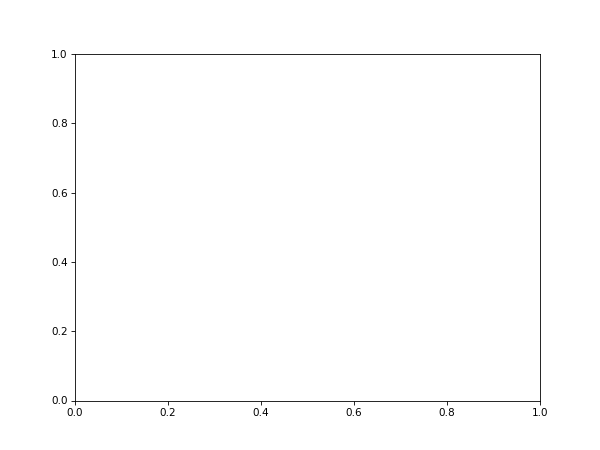

ValueError: setting an array element with a sequence.

In [22]:
# work on extended df
df = df_slaser

# extract SNR/LW before realignment
snr_list = df["dataset_raw_analysis-results_zero-filling_snr"]
lw_list = df["dataset_raw_analysis-results_zero-filling_lw"]
na_realigning_list = df["reco_pipeline_job_realigning_moving_averages"]
na_datarej_list = df["reco_pipeline_job_realigning_moving_averages"]

"""
fig = plt.figure()
ax = fig.subplots()
ax.scatter(snr_list, na_realigning_list, s=100)
ax.grid('on')
ax.set_xlabel("SNR", fontsize=11)
ax.set_ylabel("Moving average window (realign)", fontsize=11)

fig = plt.figure()
ax = fig.subplots()
ax.scatter(snr_list, na_datarej_list, s=100)
ax.grid('on')
ax.set_xlabel("SNR", fontsize=11)
ax.set_ylabel("Moving average window (datarej)", fontsize=11)
"""

mystere = df["dataset_raw_data__data_rejection[0]_Pre-rejection_measurements"]

fig = plt.figure()
ax = fig.subplots()
ax.scatter(mystere, na_realigning_list, s=100)
ax.grid('on')
ax.set_xlabel("", fontsize=11)
ax.set_ylabel("Moving average window (realign)", fontsize=11)

fig = plt.figure()
ax = fig.subplots()
ax.scatter(mystere, na_datarej_list, s=100)
ax.grid('on')
ax.set_xlabel("", fontsize=11)
ax.set_ylabel("Moving average window (datarej)", fontsize=11)


# Shimming: what is the best? 1st vs. 2nd order?
- Did 2nd order shim help? Extracting data from notebooks.

In [ ]:
# found this in my labbooks:
patient_list = [313,     319,     328, 329, 333, 336,  338,  300,    311,  336,  319,  313,  314,  349  ]
study_list = [    1,       1,       1,   1,   1,   1,    1,    2,      2,    1,    2,    2,    2,    2  ]
lw_linear = [    45,      25,      25,  30,  45,  30,   25,   35, np.nan,  np.nan,   39,   30,   20,   26  ]
lw_full = [      55,  np.nan,      40,  25,  50,  60,   35, 37.5,     25,   27,  np.nan,   50,   25,   30  ]

lw_linear = np.array(lw_linear)
lw_full = np.array(lw_full)
lw_diff = lw_full - lw_linear
lw_diff = lw_diff[~np.isnan(lw_diff)]
print("In average, there was a %.2fHz change for the water LW between 1st and 2nd order shimming!" % lw_diff.mean())


# Scan-time, number of averages and data rejection

## Theoretical, effective (gated) and post-cor. acquisition duration
Compare theory, effective acquisition durations and "useful" acquisition durations (post-correction)

In [ ]:
# calculate theoretical scan time knowing NA and TR, neglicting resp. trig
df["dataset_acqtime"] = [o.tr / 1000.0 * (o.na + o.ds)  for o in df["dataset_raw_data__sequence_obj"]]
df["dataset_acqtime_eff"] = df["dataset_raw_data__sequence_eff_acquisition_time"]

# calculating data rejection rate
df["dataset_rejetion_rate_prct"] = (df["dataset_raw_data__data_rejection[0]_Pre-rejection_na"] - 
 df["dataset_raw_data__data_rejection[0]_Post-rejection_na"]) / df["dataset_raw_data__data_rejection[0]_Pre-rejection_na"] * 100.0

# calculating usefull acqusition time post-correction
df["dataset_acqtime_usefull"] = df["dataset_raw_data__sequence_eff_acquisition_time"] - (
    df["dataset_raw_data__sequence_eff_acquisition_time"] * df["dataset_rejetion_rate_prct"] / 100.0)

cm = plt.cm.get_cmap('jet')
fig, ax = plt.subplots()
sc0 = ax.scatter(df["dataset_acqtime"], df["dataset_snr_norm_voxpos"], c=df["dataset_rejetion_rate_prct"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("Total aquisition time (s)", fontsize=11)
ax.set_xticklabels(df["dataset_acqtime"])
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%M:%S"))
ax.set_xlim([df["dataset_acqtime"].min(), df["dataset_acqtime"].max()])
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("SNR norm. vs. acq. time vs. data rejection rate")
ax.grid(True)

plt.colorbar(sc0)

fig, ax = plt.subplots()
sc0 = ax.scatter(df["dataset_voxel_vol_cm3"], df["dataset_rejetion_rate_prct"], s=100, alpha=0.5, cmap=cm)
ax.set_xlabel("", fontsize=11)
ax.set_ylabel("SNR (u.a)", fontsize=11)
ax.set_title("")
ax.grid(True)

# relative gain estimations between
# theory and effective durations
# effective durations and post-corrected durations

df["dataset_acqtime_eff_gain"] = (df["dataset_acqtime_eff"] - df["dataset_acqtime"]) / df["dataset_acqtime"] * 100.0
df["dataset_acqtime_usefull_gain"] = (df["dataset_acqtime_usefull"] - df["dataset_acqtime_eff"]) / df["dataset_acqtime_eff"] * 100.0

xlabels = ["Theory vs. Effective", "Effective vs. Useful"]

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(2)
ax.bar(pos_bars, [df["dataset_acqtime_eff_gain"].mean(), 
                  df["dataset_acqtime_usefull_gain"].mean()],
       yerr=[df["dataset_acqtime_eff_gain"].std(), 
                  df["dataset_acqtime_usefull_gain"].std()])
ax.grid('on')
ax.set_ylabel("Acquisition time gain (%)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)  



## Group-averaged rejected spectrum (need to fix this with SC)
Average over all subjects the data rejected into one crappy spectrum

In [ ]:
#init
s_arr = None
dt_final = 0.0001

fig = plt.figure()
ax = fig.subplots()

# extract rej spectrum for each dataset
for s in df["dataset_raw_data__data_rejection[0]_Rejected spectrum_obj"]:
    # resample so that all data can be averaged
    old_t = np.arange(0, s.shape[0] * s.dt, s.dt)
    new_t = np.arange(0, s.shape[0] * dt_final, dt_final) 

    s_interp = np.interp(new_t, old_t, s)

    # convert to suspect
    s_MRSData = suspect.MRSData(s_interp, dt_final, s.f0)
    s_MRSData2 = s_MRSData.view(reco.MRSData2)        

    s_MRSData2 = s_MRSData2.correct_zerofill_nd()
    if(s_arr is None):
        s_arr = s
    else:
        s_arr = np.vstack((s_arr, s_MRSData2))

    ax.plot(s_MRSData2.frequency_axis_ppm(), np.real(s_MRSData2.spectrum()))

ax.grid('on')
ax.set_xlim(5, 0)
ax.set_xlabel("chemical shift (ppm)")
ax.set_ylabel("rejected spectra (real part)")

# make the average + std plot
s_mean = np.mean(s_arr, axis=0)
s_mean = suspect.MRSData(s_mean, dt_final, s.f0)
s_mean = s_mean.view(reco.MRSData2)

s_std = np.std(s_arr, axis=0)
s_std = suspect.MRSData(s_std, dt_final, s.f0)
s_std = s_std.view(reco.MRSData2)

fig = plt.figure()
ax = fig.subplots()
ax.plot(s_mean.frequency_axis_ppm(), np.real(s_mean.spectrum()))
ax.grid('on')
ax.set_xlim(5, 0)
ax.set_xlabel("chemical shift (ppm)")
ax.set_ylabel("average rejected spectra (real part)")


## Frequency realignment, data rejection: performance in terms of SNR and LW
- Evaluate data rejection approach with peak properties estimated before and after :)

In [ ]:
# extract SNR and LW estimation regarding frequency realignment and data rejection 
snr_before_datarej1 = df["dataset_raw_data__data_rejection[0]_Pre-rejection_snr"]
snr_before_datarej2 = df["dataset_raw_analysis-results_frequency realigning_snr"]
snr_after_datarej1 = df["dataset_raw_data__data_rejection[0]_Post-rejection_snr"]
snr_after_datarej2 = df["dataset_raw_analysis-results_data rejecting_snr"]
#
lw_before_datarej1 = df["dataset_raw_data__data_rejection[0]_Pre-rejection_lw"]
lw_before_datarej2 = df["dataset_raw_analysis-results_frequency realigning_lw"]
lw_after_datarej1 = df["dataset_raw_data__data_rejection[0]_Post-rejection_lw"]
lw_after_datarej2 = df["dataset_raw_analysis-results_data rejecting_lw"]
#
snr_before_realign = df["dataset_raw_analysis-results_apodizing_snr"]
snr_after_realign = df["dataset_raw_analysis-results_frequency realigning_snr"]
#
lw_before_realign = df["dataset_raw_analysis-results_apodizing_lw"]
lw_after_realign = df["dataset_raw_analysis-results_frequency realigning_lw"]

# SNR and LW gain calculation
snr_gain_datarej1 = (snr_after_datarej1 - snr_before_datarej1) / snr_before_datarej1 * 100.0
snr_gain_datarej2 = (snr_after_datarej2 - snr_before_datarej2) / snr_before_datarej2 * 100.0
lw_gain_datarej1 = (lw_after_datarej1 - lw_before_datarej1)
lw_gain_datarej2 = (lw_after_datarej2 - lw_before_datarej2)
#
snr_gain_realign = (snr_after_realign - snr_before_realign) / snr_before_realign * 100.0
lw_gain_realign = (lw_after_realign - lw_before_realign)

xlabels = ["Data rejection (1)", "Data rejection (2)", "Freq. realignment"]

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [snr_gain_datarej1.mean(), 
                  snr_gain_datarej2.mean(), 
                  snr_gain_realign.mean()], 
       yerr=[snr_gain_datarej1.std(), 
             snr_gain_datarej2.std(), 
             snr_gain_realign.std()])
ax.grid('on')
ax.set_ylabel("Relative SNR gain (%)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)       

fig = plt.figure()
ax = fig.subplots()
pos_bars = np.arange(3)
ax.bar(pos_bars, [lw_gain_datarej1.mean(), 
                  lw_gain_datarej2.mean(), 
                  lw_gain_realign.mean()], 
       yerr=[lw_gain_datarej1.std(), 
             lw_gain_datarej2.std(), 
             lw_gain_realign.std()])
ax.grid('on')
ax.set_ylabel("LW change (Hz)")
ax.set_xticks(pos_bars)
ax.set_xticklabels(xlabels, rotation=90)   
        

# Compare no trig, cardiac and resp gating
For subjects where scanned in the same study using various gating methods
* compare final SNR and LW
* compare peak properties variability (before data rejection)

In [ ]:

# find scans identical except for gating parameter
def sel_gating_tests(dataset_entry):
    if( (dataset_entry["patient"] == 300 and dataset_entry["study"] == 1) or
        (dataset_entry["patient"] == 307 and dataset_entry["study"] == 1) or
        (dataset_entry["patient"] == 311 and dataset_entry["study"] == 2) or
        (dataset_entry["patient"] == 336 and dataset_entry["study"] == 2) )
    r = (True)
    return(r)

rdb_sel_gating_tests = rdb.select_datasets(sel_gating_tests)

# extract SNR and LW estimation regarding frequency realignment and data rejection
gating_mode_header = [sim.gating_signal_source.NO_GATING, sim.gating_signal_source.CARDIAC_ECG, sim.gating_signal_source.CARDIAC_GATING, sim.gating_signal_source.RESP_GATING]
gating_none_cardiac_resp_list = np.full([4, 4], False)

snr_precor_none_cardiac_resp_list = np.full([4, 4], None)
lw_precor_none_cardiac_resp_list = np.full([4, 4], None)
snr_postcor_none_cardiac_resp_list = np.full([4, 4], None)
lw_postcor_none_cardiac_resp_list = np.full([4, 4], None)
peak_prop_mean_list = np.full([4, 4], None)
peak_prop_std_list = np.full([4, 4], None)

k_scan = -1
for this_patient in rdb_sel:
    for this_study in rdb_sel[this_patient]:
        k_scan += 1
        for this_scan in rdb_sel[this_patient][this_study]:
            # gating mode?
            g = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].sequence.gating_mode
            
            if(g == sim.gating_signal_source.NO_GATING):
                ind_gating = 0
            elif(g == sim.gating_signal_source.CARDIAC_ECG):
                ind_gating = 1
            elif(g == sim.gating_signal_source.CARDIAC_GATING):
                ind_gating = 2
            elif(g == sim.gating_signal_source.RESP_GATING):
                ind_gating = 3
                
            peak_prop = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["data"].data_rejection[0]["Pre-rejection"]["measurements"]
            amp_mean = np.mean(peak_prop[:,0])
            amp_std = np.std(peak_prop[:,0])
            lw_mean = np.mean(peak_prop[:,1])
            lw_std = np.std(peak_prop[:,1])
            f_mean = np.mean(peak_prop[:,2])
            f_std = np.std(peak_prop[:,2]) 
            ph_mean = np.mean(peak_prop[:,3])
            ph_std = np.std(peak_prop[:,3])
            
            # snr and lw before cor
            snr_before_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["snr"]
            lw_before_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["apodizing"]["lw"]
            # snr and lw after cor
            snr_after_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["snr"]
            lw_after_realign = rdb_sel_gating_tests[this_patient][this_study][this_scan]["dataset"]["raw"]["analysis-results"]["frequency realigning"]["lw"]
                        
            # store
            gating_none_cardiac_resp_list[k_scan, ind_gating] = True
            snr_precor_none_cardiac_resp_list[k_scan, ind_gating] = snr_before_realign
            lw_precor_none_cardiac_resp_list[k_scan, ind_gating] = lw_before_realign
            snr_postcor_none_cardiac_resp_list[k_scan, ind_gating] = snr_after_realign
            lw_postcor_none_cardiac_resp_list[k_scan, ind_gating] = lw_after_realign
            peak_prop_mean_list[k_scan, ind_gating] = [amp_mean, lw_mean, f_mean, ph_mean]
            peak_prop_std_list[k_scan, ind_gating] = [amp_std, lw_std, f_std, ph_std]
     
        
        
        
        
        
        
        

# Quantification: group results...

In [ ]:
# %% init
from IPython import get_ipython
import matplotlib.pylab as plt
import matplotlib.colors as coco
from matplotlib import dates
from datetime import datetime
import mrs.reco as reco
import mrs.fit as fit
import mrs.sim as sim
import mrs.log as log
import mrs.aliases as xxx
import mrs.paths as default_paths
import numpy as np
import pickle
get_ipython().magic("clear")
plt.close("all")

get_ipython().magic("matplotlib notebook")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.max_open_warning'] = 1000
plt.rcParams["figure.figsize"] = [8, 6]
log.setLevel(log.DEBUG)

import os
os.chdir("/home/tangir/crmbm/python/shrimp")


fdb = fit.data_db("/home/tangir/crmbm/data_fit/sc_db.pkl")


In [ ]:
# %% find best fit ever omg: probably Yolanda P2
snr_ts = 30
crb_ts = 5

def select_func_yo(d, rp, fp, dp):
    kl = list(rp._analyze_results_dict[d.display_label]["snr"].keys())
    last_job = kl[-1]
    final_snr = rp._analyze_results_dict[d.display_label]["snr"][last_job]

    params_fit_CRBs_rel = dp["params_fit_CRBs_rel"]
    CRBs_ok = (params_fit_CRBs_rel[xxx.m_Cho_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_Cr_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_NAA_CH3, xxx.p_cm] < crb_ts)
    
    r = (not d.is_dicom and
         "IR" not in d.display_label and
         d.sequence.name == "eja_svs_slaser" and
         CRBs_ok and
         final_snr > snr_ts)
    return(r)

data_list, data_reco_pipeline_list, data_fit_pipeline_list, pars_list = fdb.get_datasets(select_func_yo)

data = data_list[0]
params_fit_final = sim.params(data_fit_pipeline_list[0]._meta_bs)
params_fit_final[:] = pars_list[0]["params_fit_final"]
seq = data.sequence
seq.initialize()
params_fit_final.linklock[xxx.m_Cho_CH3, xxx.p_cm] = -500
params_fit_final.linklock[xxx.m_Cho_CH2, xxx.p_cm] = 500
params_fit_final.linklock[xxx.m_Cr_CH3, xxx.p_cm] = -600
params_fit_final.linklock[xxx.m_Cr_CH2, xxx.p_cm] = 600
params_fit_final.linklock[xxx.m_NAA_CH3, xxx.p_cm] = -700
params_fit_final.linklock[xxx.m_NAA_CH2, xxx.p_cm] = 700

data.display_spectrum_1d()

# fit plot
fig, ax = plt.subplots()
fit.disp_fit(ax, data, params_fit_final, seq, True, True, [xxx.m_Cho_CH3, xxx.m_Cho_CH2, xxx.m_Cr_CH3, xxx.m_Cr_CH2, xxx.m_Gln, xxx.m_Glu, xxx.m_NAA_CH3, xxx.m_NAA_CH2, xxx.m_mI])
fig.savefig("fig_fit.svg")

In [ ]:
# %% P1 : find one good scan per volunteer, best in terms of SNR
snr_ts = 5
crb_ts = 10

def select_func_yo(d, rp, fp, dp):
    kl = list(rp._analyze_results_dict[d.display_label]["snr"].keys())
    last_job = kl[-1]
    final_snr = rp._analyze_results_dict[d.display_label]["snr"][last_job]

    params_fit_CRBs_rel = dp["params_fit_CRBs_rel"]
    CRBs_ok = (params_fit_CRBs_rel[xxx.m_Cho_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_Cr_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_NAA_CH3, xxx.p_cm] < crb_ts)
    
    r = (not d.is_dicom and
         "IR" not in d.display_label and
         "P1" in d.patient_name and
         d.sequence.name == "eja_svs_slaser" and
         CRBs_ok and
         final_snr > snr_ts)
    return(r)

data_list_P1, data_reco_pipeline_list_P1, data_fit_pipeline_list_P1, pars_list_P1 = fdb.get_datasets(select_func_yo)

data_list_P1_2 = []
data_reco_pipeline_list_P1_2 = []
data_fit_pipeline_list_P1_2 = []
pars_list_P1_2 = []

ind_scanned = []
# keep best scan for each patient
for i, d in enumerate(data_list_P1):
    if(i not in ind_scanned):
        # find duplicates
        ind_patients = []
        for j, d2 in enumerate(data_list_P1):
            if(j not in ind_scanned and d.patient_name == d2.patient_name):
                ind_patients.append(j)
                ind_scanned.append(j)

        # find best snr
        best_snr = 0
        best_snr_ind = 0
        for k in ind_patients:
            dl = data_list_P1[k].display_label
            rp = data_reco_pipeline_list_P1[k]
            kl = list(rp._analyze_results_dict[dl]["snr"].keys())
            last_job = kl[-1]
            final_snr = rp._analyze_results_dict[dl]["snr"][last_job]

            if(final_snr >= best_snr):
                best_snr = final_snr
                best_snr_ind = k

        # got the highest snr scan for this patient
        data_list_P1_2.append(data_list_P1[best_snr_ind])
        data_reco_pipeline_list_P1_2.append(data_reco_pipeline_list_P1[best_snr_ind])
        data_fit_pipeline_list_P1_2.append(data_fit_pipeline_list_P1[best_snr_ind])
        pars_list_P1_2.append(pars_list_P1[best_snr_ind])

data_list_P1 = data_list_P1_2
data_reco_pipeline_list_P1 = data_reco_pipeline_list_P1_2
data_fit_pipeline_list_P1 = data_fit_pipeline_list_P1_2
pars_list_P1 = pars_list_P1_2
    
print("")
print("Filtered by SNR and sorted:")
patient_name_list = []
for d in data_list_P1:
    patient_name_list.append(d.patient_name)
patient_name_list.sort()

for p in patient_name_list:
    print(p)


In [ ]:
pars_abs_water_all = []
pars_abs_cre_all = []
pars_ratio_cre_all = []
for this_pars in pars_list_P1:
    pp = this_pars["params_fit_final_Ts_abs_water"]
    pars_abs_water_all.append(pp.copy())
    
    pp = this_pars["params_fit_final_Ts"]
    pp[:, xxx.p_cm] = pp[:, xxx.p_cm] * 7.5 / pp[xxx.m_Cr_CH3, xxx.p_cm]
    pars_abs_cre_all.append(pp.copy())
    
    pp = this_pars["params_fit_final_Ts"]
    pp[:, xxx.p_cm] = pp[:, xxx.p_cm] / pp[xxx.m_Cr_CH3, xxx.p_cm]
    pars_ratio_cre_all.append(pp.copy())
    
pars_abs_water_all = np.array(pars_abs_water_all)
pars_abs_cre_all = np.array(pars_abs_cre_all)
pars_ratio_cre_all = np.array(pars_ratio_cre_all)

pars_abs_water_mean = sim.params(data_fit_pipeline_list_P1[0]._meta_bs)
pars_abs_water_mean[:] = np.mean(pars_abs_water_all, axis=0)
pars_abs_water_std = np.std(pars_abs_water_all, axis=0)

pars_abs_cre_mean = sim.params(data_fit_pipeline_list_P1[0]._meta_bs)
pars_abs_cre_mean[:] = np.mean(pars_abs_cre_all, axis=0)
pars_abs_cre_std = np.std(pars_abs_cre_all, axis=0)

# human range
p_human_min = sim.params(data_fit_pipeline_list_P1[0]._meta_bs).set_default_min()
p_human_max = sim.params(data_fit_pipeline_list_P1[0]._meta_bs).set_default_max()

fig, ax = plt.subplots()
fit.disp_bargraph(ax, [p_human_min, pars_abs_water_mean, pars_abs_cre_mean, p_human_max], [p_human_min*0, pars_abs_water_std, pars_abs_cre_std, p_human_max*0], ["Healthy human brain min/max concentration range", "Estimated concentrations", "Estimated concentrations assuming Cre", "Healthy human brain min/max concentration range"], False, False, False, False, xxx.p_cm, [xxx.m_Cho_CH3, xxx.m_Cr_CH3, xxx.m_Gln, xxx.m_Glu, xxx.m_NAA_CH3, xxx.m_mI], 0.2)
ax.set_ylim([0, 25])
ax.set_xticklabels(["tCho", "tCr", "Gln", "Glu", "mI", "NAA"], rotation=0)
ax.set_ylabel("Abs. concentration [mmol/kg]")
fig.savefig("fig_group_mean.svg")

pars_ratio_cre_mean = sim.params(data_fit_pipeline_list_P1[0]._meta_bs)
pars_ratio_cre_mean[:] = np.mean(pars_ratio_cre_all, axis=0)
pars_ratio_cre_std = np.std(pars_ratio_cre_all, axis=0)

print("tCho/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_Cho_CH3, xxx.p_cm], pars_ratio_cre_std[xxx.m_Cho_CH3, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_Cho_CH3, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_Cho_CH3, xxx.p_cm]))
print("Gln/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_Gln, xxx.p_cm], pars_ratio_cre_std[xxx.m_Gln, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_Gln, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_Gln, xxx.p_cm]))
print("Glu/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_Glu, xxx.p_cm], pars_ratio_cre_std[xxx.m_Glu, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_Glu, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_Glu, xxx.p_cm]))
print("mI/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_mI, xxx.p_cm], pars_ratio_cre_std[xxx.m_mI, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_mI, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_mI, xxx.p_cm]))
print("NAA/tCre = %.2f +/- %.2f CV = %.0f" % (pars_ratio_cre_mean[xxx.m_NAA_CH3, xxx.p_cm], pars_ratio_cre_std[xxx.m_NAA_CH3, xxx.p_cm], 100 * pars_ratio_cre_std[xxx.m_NAA_CH3, xxx.p_cm]/pars_ratio_cre_mean[xxx.m_NAA_CH3, xxx.p_cm]))


In [ ]:
# %% P2 : find one good scan per volunteer, best in terms of SNR
snr_ts = 5
crb_ts = 10

def select_func_yo(d, rp, fp, dp):
    kl = list(rp._analyze_results_dict[d.display_label]["snr"].keys())
    last_job = kl[-1]
    final_snr = rp._analyze_results_dict[d.display_label]["snr"][last_job]

    params_fit_CRBs_rel = dp["params_fit_CRBs_rel"]
    CRBs_ok = (params_fit_CRBs_rel[xxx.m_Cho_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_Cr_CH3, xxx.p_cm] < crb_ts and 
    params_fit_CRBs_rel[xxx.m_NAA_CH3, xxx.p_cm] < crb_ts)
    
    r = (not d.is_dicom and
         "IR" not in d.display_label and
         "P2" in d.patient_name and
         d.sequence.name == "eja_svs_slaser" and
         CRBs_ok and
         final_snr > snr_ts)
    return(r)

data_list_P2, data_reco_pipeline_list_P2, data_fit_pipeline_list_P2, pars_list_P2 = fdb.get_datasets(select_func_yo)

data_list_P2_2 = []
data_reco_pipeline_list_P2_2 = []
data_fit_pipeline_list_P2_2 = []
pars_list_P2_2 = []

ind_scanned = []
# keep best scan for each patient
for i, d in enumerate(data_list_P2):
    if(i not in ind_scanned):
        # find duplicates
        ind_patients = []
        for j, d2 in enumerate(data_list_P2):
            if(j not in ind_scanned and d.patient_name == d2.patient_name):
                ind_patients.append(j)
                ind_scanned.append(j)

        # find best snr
        best_snr = 0
        best_snr_ind = 0
        for k in ind_patients:
            dl = data_list_P2[k].display_label
            rp = data_reco_pipeline_list_P2[k]
            kl = list(rp._analyze_results_dict[dl]["snr"].keys())
            last_job = kl[-1]
            final_snr = rp._analyze_results_dict[dl]["snr"][last_job]

            if(final_snr >= best_snr):
                best_snr = final_snr
                best_snr_ind = k

        # got the highest snr scan for this patient
        data_list_P2_2.append(data_list_P2[best_snr_ind])
        data_reco_pipeline_list_P2_2.append(data_reco_pipeline_list_P2[best_snr_ind])
        data_fit_pipeline_list_P2_2.append(data_fit_pipeline_list_P2[best_snr_ind])
        pars_list_P2_2.append(pars_list_P2[best_snr_ind])

data_list_P2 = data_list_P2_2
data_reco_pipeline_list_P2 = data_reco_pipeline_list_P2_2
data_fit_pipeline_list_P2 = data_fit_pipeline_list_P2_2
pars_list_P2 = pars_list_P2_2

print("")
print("Filtered by SNR and sorted:")
patient_name_list = []
for d in data_list_P2:
    patient_name_list.append(d.patient_name)
patient_name_list.sort()

for p in patient_name_list:
    print(p)

In [ ]:
# merge with previous P1s
data_list_P1P2 = data_list_P1 + data_list_P2
data_reco_pipeline_list_P1P2 = data_reco_pipeline_list_P1 + data_reco_pipeline_list_P2
data_fit_pipeline_list_P1P2 = data_fit_pipeline_list_P1 + data_fit_pipeline_list_P2
pars_list_P1P2 = pars_list_P1 + pars_list_P2

# sort according to number
patient_name_list = []
for d in data_list_P1P2:
    patient_name_list.append(d.patient_name)
    
patient_name_list = np.array(patient_name_list)
inds = np.argsort(patient_name_list)

data_list_P1P2_sorted = []
data_reco_pipeline_list_P1P2_sorted = []
data_fit_pipeline_list_P1P2_sorted = []
pars_list_P1P2_sorted = []
for ii in inds:
    data_list_P1P2_sorted.append(data_list_P1P2[ii])
    data_reco_pipeline_list_P1P2_sorted.append(data_reco_pipeline_list_P1P2[ii])
    data_fit_pipeline_list_P1P2_sorted.append(data_fit_pipeline_list_P1P2[ii])
    pars_list_P1P2_sorted.append(pars_list_P1P2[ii])

patient_names = []
for d in data_list_P1P2_sorted:
    patient_names.append(d.patient_name)
    print(d.patient_name)


In [ ]:
pars_abs_water_all = []
pars_abs_cre_all = []
pars_crb_water_all = []
pars_crb_cre_all = []
caption_list = []
P1P2s_list = [300, 304, 311, 313, 314, 319, 333, 336]
P1P2s_list = [311, 313, 314, 319]  # to set manually....

for this_pars, this_pn in zip(pars_list_P1P2_sorted, patient_names):
    this_patient_number = int(this_pn[0:3])
    if(this_patient_number in P1P2s_list):
        pp = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp[:] = this_pars["params_fit_final_Ts_abs_water"]
        pars_abs_water_all.append(pp)
        # crb
        pp2 = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp2[:] = this_pars["params_fit_final_Ts_abs_water"] * this_pars["params_fit_CRBs_rel"] / 100.0
        pars_crb_water_all.append(pp2)
        
        pp3 = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp3[:] = this_pars["params_fit_final_Ts_abs_water"]
        pp3[:, xxx.p_cm] = pp3[:, xxx.p_cm] / pp3[xxx.m_Cr_CH3, xxx.p_cm]
        pars_abs_cre_all.append(pp3)
        # crb
        pp4 = sim.params(data_fit_pipeline_list_P1P2_sorted[0]._meta_bs)
        pp4[:, xxx.p_cm] = this_pars["params_fit_final_Ts_abs_water"][:, xxx.p_cm]/this_pars["params_fit_final_Ts_abs_water"][xxx.m_Cr_CH3, xxx.p_cm] * (this_pars["params_fit_CRBs_abs"][:, xxx.p_cm]/this_pars["params_fit_final_Ts_abs_water"][:, xxx.p_cm] + this_pars["params_fit_CRBs_abs"][xxx.m_Cr_CH3, xxx.p_cm]/this_pars["params_fit_final_Ts_abs_water"][xxx.m_Cr_CH3, xxx.p_cm])
        pars_crb_cre_all.append(pp4)

        caption_list.append(this_pn)

fig, ax = plt.subplots()
fit.disp_bargraph(ax, pars_abs_water_all, pars_crb_water_all, caption_list, False, False, False, False, xxx.p_cm, [xxx.m_Cho_CH3, xxx.m_Cr_CH3, xxx.m_NAA_CH3, xxx.m_mI], 0.1)
ax.set_xticklabels(["tCho", "tCr", "mI", "NAA"], rotation=0)
ax.set_ylabel("Abs. concentration [mmol/kg]")
fig.savefig("fig_group_repro_cm_abs.svg")

fig, ax = plt.subplots()
fit.disp_bargraph(ax, pars_abs_cre_all, pars_crb_cre_all, caption_list, False, False, False, False, xxx.p_cm, [xxx.m_Cho_CH3, xxx.m_Cr_CH3, xxx.m_NAA_CH3, xxx.m_mI], 0.1)
ax.set_xticklabels(["tCho", "tCr", "mI", "NAA"], rotation=0)
ax.set_ylabel("Cr ratios")
fig.savefig("fig_group_repro_ratios.svg")


# Some more questions

* Try IMG ! 
* How long shoud we scan vs. SNR vs. BMI (including all NAs)
* Data rejection rate vs. SNR/BMI/vref...
* Choosing SNR/LW threshold
* Percentage of exploitable scans/patients

* compare protocols 20/1, 10/2, 5/5 when possible

* Water LW looks visually good in SC compared to brain right? So why is the data so different?

* Find why MRS quality data varies from one subject to another (THIS IS CRITICAL)
    * Things to check:
    * B0 (LW)
    * B1 (Vref)
    * BMI stuff (height/weight)
    * unperfect breathing gating (check respiratory stability?)
    * susceptiblity effects (check LW variation STD)
    * lungs are closer to SC for small subjects (check voxel position, subject height)
    * When doing this, normalize SNR per volume, NA, include NA rejected ? already done? voxel size, position ?

* SNR according to NA plot, normalized or not

* check for intra-subject repro if any data

* What does CRB errors depend on? scatter plots CRBS(met) = f(SNR, FWHM)
    * Use this to choose which metabolites to include, how many NA are really needed

* CRBs: relative / absolute? work according to the last quantification review!

* Percentage of acceptable or quantifiable MR spectra?

* About the >4.7ppm artefact, correlate with shimming voltages too

* What about heart and resp bpm?